# Computation of shape contour and area during growth of propagules.


##  Documentation and Imports


Created on 27-05-2021

Author: Valentin Laplaud

This code aims to compute the shape of propagules growing in microfluidic chips. It detects gemmae contours using binarization, and saves the data of the contour position on the image, as well as the area and geometrical center position of each gemmae. 

A second part fits the evolution of gemmae in time with a delayed exponential.

In [17]:
## Clean up before script start 

for element in dir():

    if element[0:1] != "_":

        del globals()[element]

import gc
gc.collect()

# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2
mpl.rcParams['axes.facecolor'] = COLOR2

#Default colors
import matplotlib.pyplot as plt
from cycler import cycler
colorcycle = [plt.get_cmap('gist_rainbow')(1. * i/30) for i in range(30)]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)

# numbers handling
import numpy as np
import pandas as pd
from itertools import compress

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit, least_squares

# images handling
from skimage import io
from skimage.filters import threshold_otsu, threshold_mean, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion, binary_dilation
from skimage.color import rgb2gray, rgb2hsv
from skimage.segmentation import active_contour
import cv2 as cv

# to hide known warnings
import warnings
warnings.filterwarnings("ignore")

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../')
import VallapFunc as vf


##  Define analysis functions



###  Image binarization
Binarize images from experiment and save them in a new folder to be used for contour and area detection.

#### Circular mask
create the circle for opening and closing operation

In [18]:
def create_circular_mask(h, w, center=None, radius=None):


    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

#### Binarize
Transform the RGB image into a HSV image, and then thresholds it using the two boundary triplets HSVmin and HSVmax. Binary morphological operations are then applied to clean up he shape.

In [19]:
def Binarize(Img, Scale, HSVmin, HSVmax, **kwargs):

    #init and read kwargs
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value
            

    
    hsv = cv.cvtColor(Img, cv.COLOR_RGB2HSV)

    ## mask of green 
    mask = cv.inRange(hsv, HSVmin, HSVmax)

    ## slice the green
    BWimg = mask>0
    
    size = np.round(5*Scale) # 5µm in pixels
    
    selem = create_circular_mask(size,size) # create circular element for opening

    DilBWimg = binary_closing(BWimg,selem) # image opening
    
    
    FilledBWimg = remove_small_holes(DilBWimg, area_threshold=1e3) # fills dark regions
    
    Size = np.round(30*Scale) # 30µm in pixels
    
    Selem = create_circular_mask(Size,Size) # create circular element for opening

    FinalImg = binary_opening(FilledBWimg,Selem) # image opening
    
    if DebugPlots:        
       
        DilBWonImg = np.multiply(Img,np.repeat(DilBWimg[:, :, np.newaxis], 3, axis=2))
        FinalOnImg = np.multiply(Img,np.repeat(FinalImg[:, :, np.newaxis], 3, axis=2))
        BWonImgInv =np.multiply(Img,np.repeat(np.invert(BWimg[:, :, np.newaxis]), 3, axis=2))
        DilBWonImgInv = np.multiply(Img,np.repeat(np.invert(DilBWimg[:, :, np.newaxis]), 3, axis=2))
        FinalOnImgInv = np.multiply(Img,np.repeat(np.invert(FinalImg[:, :, np.newaxis]), 3, axis=2))
        
        fig, [[ax0, ax1, ax2], [ax3, ax4, ax5]] = plt.subplots(nrows = 2, ncols=3,dpi = 500)    
        fig.suptitle('Debug plots for "Binarize" function :')
        ax0.imshow(Img, cmap='gray')
        ax0.set_title("Original & Thresholded images")
        ax0.axis('off')
        ax3.imshow(BWonImgInv, cmap='gray')
        ax3.axis('off')
        ax1.imshow(DilBWonImgInv, cmap='gray')
        ax1.set_title("Closed image")
        ax1.axis('off') 
        ax2.imshow(FinalOnImgInv, cmap='gray')
        ax2.set_title("Final mask")
        ax2.axis('off')        
        fig.tight_layout()
        ax4.imshow(DilBWonImg, cmap='gray')
        ax4.axis('off') 
        ax5.imshow(FinalOnImg, cmap='gray')
        ax5.axis('off')        
        fig.tight_layout()
        plt.show()
        
        print('')
    
    return(FinalImg)

#### Binarize stack
 Wrapper function that applies binarization to stacks of images and saves them. Adjusts the white balance before binarization.

In [20]:
def BinarizeStack(StackList, P, Scale, **kwargs):

    #init and read kwargs
    DebugPlots = False                            
    HSVmin = (30, 20, 70)
    HSVmax = (60, 120,220)
    ImgList = [0, 20, 40]
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value 
        elif key == 'debuglist':
            ImgList = value 
        elif key == 'HSVrange':
            HSVmin = value[0]
            HSVmax = value[1]
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
            
    if os.path.exists(P + '\\WhiteBalanceData.csv'):
        WBsaving = pd.read_csv(P + '\\WhiteBalanceData.csv', index_col = 'Ind')
    else:                
        WBsaving = pd.DataFrame(data=None,columns=['lum','whiteR','whiteG','whiteB']) 
    
    
    for s in StackList:

        print('Processing ' + s + ' :')    

        RGBstack = io.imread(P + '\\' + s + '.tif') # get the tiff stack
        Bckp_RGBstack = io.imread(P + '\\' + s + '.tif') # get the tiff stack for comparison
        Index = WBsaving.index
        
        #### adjusting white balance
        if WBsaving.loc[(WBsaving.index == s)].empty:            
            # ask user to click
            %matplotlib qt
            plt.figure(dpi=250)
            plt.title('Select an area for white balance')
            plt.imshow(RGBstack[0])
            pts = np.asarray(plt.ginput(-1, timeout=-1))
            plt.close()
            %matplotlib inline
            
            
            # indicices of convex hull of set of points pts
            CH = ConvexHull(pts)

            # polygon defining the hull
            p = mpl.path.Path(pts[CH.vertices,:])

            # set of image pixels coordinates
            xx,yy = np.meshgrid(np.linspace(0,np.shape(RGBstack[0])[1],num=np.shape(RGBstack[0])[1],endpoint=False),
                                np.linspace(0,np.shape(RGBstack[0])[0],num=np.shape(RGBstack[0])[0],endpoint=False))

            # mask for the part of the image to use for white balance
            mask = np.reshape(p.contains_points(np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))),
                              np.shape(RGBstack[0])[0:2])

            # balancing white
            whiteR = RGBstack[0][mask,0].mean()
            whiteG = RGBstack[0][mask,1].mean()
            whiteB = RGBstack[0][mask,2].mean()
            lum = (whiteR + whiteG + whiteB)/3
            
            # Save the points that were clicked
            data = {'lum': lum,
                    'whiteR': whiteR,
                    'whiteG': whiteG,
                    'whiteB': whiteB}           
            
            WBsaving = WBsaving.append(pd.DataFrame(data=data,index = [s]))
            
            WBsaving.to_csv(P + '\\WhiteBalanceData.csv',index_label = 'Ind')
            
        else:
            whiteR = WBsaving.loc[s,'whiteR']
            whiteG = WBsaving.loc[s,'whiteG']
            whiteB = WBsaving.loc[s,'whiteB']
            lum = WBsaving.loc[s,'lum']

        RGBstack[:,:,:,0] = RGBstack[:,:,:,0] * lum / whiteR
        RGBstack[:,:,:,1] = RGBstack[:,:,:,1] * lum / whiteG
        RGBstack[:,:,:,2] = RGBstack[:,:,:,2] * lum / whiteB


        # Savefolders for Sat and Binary stacks
        if not os.path.exists(P + '\\Processed'):
            os.mkdir(P + '\\Processed') # create global folder        

        if not os.path.exists(P + '\\Processed\\' + s + '_Binarized'):
            # shutil.rmtree(P + '\\' + s + '_Binarized') # remove folder and contents
            os.mkdir(P + '\\Processed\\' + s + '_Binarized') # create binarize image folder
            isBin = False
        else:
            isBin = True

        if DebugPlots:            
            imglist = ImgList
        else:
            imglist = range(len(RGBstack))  
            #imglist = range(49)  
        
        for i in imglist:
            
            Img = RGBstack[i]
            
            if DebugPlots&0:
                fig,ax = plt.subplots(ncols=2,dpi=200)
                ax[0].set_title('Original image')
                ax[0].imshow(Bckp_RGBstack[i])
                ax[1].set_title('White balanced image')
                ax[1].imshow(Img)
                
                plt.show()
            
            # Binarization      
            if not isBin:
                print('Binarization of image ' + str(i+1) + '/' + str(len(RGBstack)).ljust(15), flush=True, end = '\r')
                
                BinImg = Binarize(Img,Scale,HSVmin,HSVmax,debug =DebugPlots)
                
                io.imsave(P + '\\Processed\\' + s + '_Binarized\\' + str(i) + '.tif', np.uint8(BinImg*255), plugin='tifffile')
            
            else:
                if os.path.exists(P + '\\Processed\\' + s + '_Binarized\\' + str(i) + '.tif'):
                    BinImg = io.imread(P + '\\Processed\\' + s + '_Binarized\\' + str(i) + '.tif') 
                else:
                    print('Binarization of image ' + str(i+1) + '/' + str(len(RGBstack)).ljust(15), flush=True, end = '\r')
                    
                    BinImg = Binarize(Img,Scale,HSVmin,HSVmax,debug =DebugPlots)
                    io.imsave(P + '\\Processed\\' + s + '_Binarized\\' + str(i) + '.tif', np.uint8(BinImg*255), plugin='tifffile')
            


        print('Binarization done for ' + str(len(RGBstack)) + '/' + str(len(RGBstack)) + ' images'.ljust(20), flush=True)

        
    return

### Contour and area computation

#### Edge and area of binary object
Identify the largest object on binary image, isolates it, and saves it area and contour. Also compute the geometrical center using a distance transform.


Open cv findcontour is based on : Satoshi Suzuki and others. Topological structural analysis of digitized binary images by border following. Computer Vision, Graphics, and Image Processing, 30(1):32–46, 1985.

In [21]:
def getEdgeAndArea(BinImg,Scale):
    
    # Find largest contour 
    cnts, _ = cv.findContours(BinImg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv.contourArea)

    Area = cv.contourArea(cnt)*Scale**2

    # Create image with only largest object
    out = np.zeros(BinImg.shape, np.uint8)
    cv.drawContours(out, [cnt], -1, 255, cv.FILLED)
    BinImg = cv.bitwise_and(BinImg, out)

    # Computing center of propagule using euclidian distance transform
    dist = cv.distanceTransform(BinImg, cv.DIST_L2, 3)
    regions = regionprops(BinImg,dist)
    center = regions[0].weighted_centroid

    # Getting contour 
    Ycnt = cnt[:,0,0]
    Xcnt = cnt[:,0,1] 
    
    ContourCumLength = np.concatenate(([0],np.cumsum(np.sqrt(np.square(np.diff(Xcnt))+np.square(np.diff(Ycnt))))))
    ContourLength = ContourCumLength[-1]
        
    ContourInterp = interp1d(ContourCumLength,[Xcnt,Ycnt], fill_value='extrapolate')            

    npts = 1000

    # create contour with regular points
    deltaS = ContourLength/npts
    ContourRegCumLength = np.linspace(0,npts,npts+1)*deltaS

    RegXcnt,RegYcnt = ContourInterp(ContourRegCumLength)
    
    # Edge coordinate relative to the center
    relativeIndicesX = RegXcnt-center[0]
    relativeIndicesY = RegYcnt-center[1]      
    
    Xlength = relativeIndicesX.max() - relativeIndicesX.min()
    Ylength = relativeIndicesY.max() - relativeIndicesY.min()
    
    return(relativeIndicesX,relativeIndicesY,center,Area,Xlength,Ylength)

#### Analyze stack
Wrapper function to analyze stack and pool contour and area data into a panda dataframe.

In [22]:
def GetContours(StackList,P, Scale, FPH, **kwargs):
      
    # init and read kwargs    
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    # initialize dataframme
    GD = pd.DataFrame(data=None,columns=['Img','Time (min)','Area','Xcenter','Ycenter']) 

    CD = pd.DataFrame(data=None,columns=['Img','Ximg','Yimg']) 

    
    for s in StackList:

        print('Processing ' + s + ' :')   
        
        # Loading video
        RGBstack = io.imread(P + '\\' + s + '.tif') # get the tiff stack
        
        n = len(RGBstack)

        jet_colorcycle = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
        mpl.rcParams['axes.prop_cycle'] = cycler(color=jet_colorcycle)        


        for i in range(n):
            
            print('Measuring contour for image ' + str(i+1) + '/' + str(len(RGBstack)).ljust(10), flush=True, end = '\r')
                        
            # Loading binary image
            BinImg = io.imread(P + '\\Processed\\' + s + '_Binarized\\' + str(i) + '.tif')

            # Computing propagule edge and area from binary image
            SortedX,SortedY,center,Area,Xlength,Ylength = getEdgeAndArea(BinImg,Scale) 
            
            # Storing contour data
            data = {'Ximg':SortedY+center[1],
                        'Yimg':SortedX+center[0],
                        'Img':i*np.ones(len(SortedX))} 

            CD = CD.append(pd.DataFrame(data=data,index = np.repeat(s,len(SortedX))))  # adding to global dataframe
            
            data2 = {'Area':Area/1000000, # In mm²
                     'Xlength':Xlength,
                     'Ylength':Ylength,
                        'Xcenter':center[1],
                        'Ycenter':center[0],
                        'Img':i,
                        'Time (min)':i*60/FPH} 
            
            GD = GD.append(pd.DataFrame(data=data2,index = [s])) 
            
            if ((i == 0)|(i == 22)|(i == 24)) & DebugPlots: #((i == 1)|(i == 21)|(i == 41)) &
                RGBimg = io.imread(P + '\\' + s + '.tif', key = i)

                plt.figure(dpi=250,facecolor='white')
                plt.title(s)
                plt.imshow(RGBimg)
                plt.plot(SortedY+center[1],SortedX+center[0],'c',lw = 0.7)
                plt.show()
                
        print('Contours saved.'.ljust(35), flush = True)
         
    return(CD,GD)

### Fit of area curve

#### Fit function
A function to fit the normalized area evolution curve. An exponential that starts after a delay.

In [23]:
def fitFunc(t,T,tdeb,A0): # Exponential growth with a delay
    
    f = np.multiply(A0,np.exp(np.divide((t-tdeb),T)))
        
    f[t<tdeb] = A0
        
    return(f)

#### Fitting data
Fit the evolution of area in time using a delayed exponential. A first fit is used to determine the approximate value of growth start time. Then the fit is repeated only on data that go until 15h after start time. This is iterrated 3 times to have a convergence of the parameters.

In [24]:
def fitAreaGrowth(StackList,Rows,GD,FPH,Delay, **kwargs):
    
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
            
    for s,row in zip(StackList,Rows):
        
        print('Fitting area curve for : ' + s.ljust(5), end='\n')           
        
        Time = GD.loc[s,'Img'].values.astype(float)/FPH*60 # in minutes
        AreaC = GD.loc[s,'Area'].values
        
        # first fit to determine tdeb
        params1, cov1 = curve_fit(f=fitFunc, xdata=Time, ydata=AreaC, p0=[100, 30, AreaC[0]], bounds=(0, np.inf), method='trf', loss='soft_l1')
        stdevs1 = np.sqrt(np.diag(cov1))
        
        R2_1 = np.round(vf.computeR2(AreaC,fitFunc(Time,params1[0],params1[1],params1[2]))*1000)/1000
                        
        # Second fit, only until 15 hours after the start of growth
        fitInterval = Time<(params1[1]+900)
        params2, cov2 = curve_fit(f=fitFunc, xdata=Time[fitInterval], ydata=AreaC[fitInterval], p0=params1,
                                  bounds=(0, np.inf), method='trf', loss='soft_l1')
        
        
        stdevs2 = np.sqrt(np.diag(cov2))
        
        R2_2 = np.round(vf.computeR2(AreaC[fitInterval],fitFunc(Time[fitInterval],params2[0],params2[1],params2[2]))*1000)/1000
        
        # Third fit, only until 15 hours after the start of growth, to confirm second
        fitInterval = Time<(params2[1]+900)
        params3, cov3 = curve_fit(f=fitFunc, xdata=Time[fitInterval], ydata=AreaC[fitInterval], p0=params2,
                                  bounds=(0, np.inf), method='trf', loss='soft_l1')
        
        
        stdevs3 = np.sqrt(np.diag(cov2))
        
        R2_3 = np.round(vf.computeR2(AreaC[fitInterval],fitFunc(Time[fitInterval],params3[0],params3[1],params3[2]))*1000)/1000
        
        
        # Fourth fit, only until 15 hours after the start of growth, to confirm third
        fitInterval = Time<(params3[1]+900)
        params4, cov4 = curve_fit(f=fitFunc, xdata=Time[fitInterval], ydata=AreaC[fitInterval], p0=params3,
                                  bounds=(0, np.inf), method='trf', loss='soft_l1')
        
        
        stdevs4 = np.sqrt(np.diag(cov2))
        
        R2_4 = np.round(vf.computeR2(AreaC[fitInterval],fitFunc(Time[fitInterval],params4[0],params4[1],params4[2]))*1000)/1000
        
        
        
        fig, [ax1,ax2] = plt.subplots(ncols=2, dpi=300)

        ax1.set_title(s + ' - tdeb = ' + str(round(params1[1]*10)/10) + ' ' + u"\u00B1" + str(round(stdevs1[1]*10)/10) + ' min.\n' +
        'T = ' + str(round(params1[0]/60*10)/10)  + ' ' + u"\u00B1" + str(round(stdevs1[0]/60*10)/10) + ' hours.\nR2 = ' 
                      + str(R2_1))
        ax1.plot(Time,AreaC,'*r',ms=3)
        ax1.plot(Time,fitFunc(Time,params1[0],params1[1],params1[2]),'--b')
        ax1.set_xlabel('Time (min)')
        ax1.set_ylabel('Area')

        ax2.set_title(s + ' - tdeb = ' + str(round(params2[1]*10)/10) + ' ' + u"\u00B1" + str(round(stdevs2[1]*10)/10) + ' min.\n' +
        'T = ' + str(round(params2[0]/60*10)/10)  + ' ' + u"\u00B1" + str(round(stdevs2[0]/60*10)/10) + ' hours.\nR2 = ' 
                      + str(R2_2))
        ax2.plot(Time,AreaC,'*r',ms=3)
        ax2.plot(Time[fitInterval],AreaC[fitInterval],'*g',ms=3)
        ax2.plot(Time,fitFunc(Time,params4[0],params4[1],params4[2]),'--b',lw=1)
        ax2.set_xlabel('Time (min)')
        ax2.set_ylabel('Area')

        fig.tight_layout()
        
        if DebugPlots:
            plt.show()
        else:
            plt.close(fig)
        

        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdeb_full'] = params1[1] + Delay
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdebShift_full'] = np.argmin(np.abs(Time-params1[1])) # img shift for alignement on tdeb
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau_full'] = params1[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'A0fit_full'] = params1[2]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDtdeb_full'] = stdevs1[1]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDTau_full'] = stdevs1[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2_full'] = R2_1
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdeb_inter1'] = params2[1] + Delay
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdebShift_inter1'] = np.argmin(np.abs(Time-params2[1])) # img shift for alignement on tdeb
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau_inter1'] = params2[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'A0fit_inter1'] = params2[2]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDtdeb_inter1'] = stdevs2[1]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDTau_inter1'] = stdevs2[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2_inter1'] = R2_2
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdeb_inter2'] = params3[1] + Delay
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdebShift_inter2'] = np.argmin(np.abs(Time-params3[1])) # img shift for alignement on tdeb
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau_inter2'] = params3[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'A0fit_inter2'] = params3[2]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDtdeb_inter2'] = stdevs3[1]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDTau_interé'] = stdevs3[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2_inter2'] = R2_3
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdeb'] = params4[1] + Delay
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'tdebShift'] = np.argmin(np.abs(Time-params4[1])) # img shift for alignement on tdeb
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau'] = params4[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'A0fit'] = params4[2]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDtdeb'] = stdevs4[1]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'STDTau'] = stdevs4[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2'] = R2_4
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'ChipRow'] = row
        
        
        ## Additionnal growth fitting (end-10h -> end) for correlation with osmotic chocs
        
        def expfitf(t,Tau):
            return(np.exp(np.divide(t,Tau)))
        
        params, cov = curve_fit(f=expfitf, xdata=Time[-20:len(Time)], ydata=AreaC[-20:len(Time)]/params4[2], p0=params4[0],
                                  bounds=(0, np.inf), method='trf', loss='soft_l1')
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau10h'] = params[0]
        GD.loc[(GD.index == s) & (GD['Img'] == 0), '1/Tau10h'] = 1/params[0]
        
        params, cov = curve_fit(f=expfitf, xdata=Time[-10:len(Time)], ydata=AreaC[-10:len(Time)]/params4[2], p0=params[0],
                                  bounds=(0, np.inf), method='trf', loss='soft_l1')
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Tau5h'] = params[0]

    
    return(GD)

#### Selection based on R2
Sort data based on the quality of the fit.

In [25]:
def selectR2s(GD, CD, Th, label, **kwargs):
    
    showHist = False
    print('Analyzing : ' + label)
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    R2sPos = ~np.isnan(GD['fitR2'].values)
    R2s = GD['fitR2'].values[R2sPos]
    goodR2s = R2s>=Th
    frac = np.round(sum(goodR2s)/len(goodR2s)*1000)/10
    
    StackList = GD.index[R2sPos].array.to_numpy()
    goodList = StackList[goodR2s]
    
    goodGD = GD.loc[goodList]
    goodCD = CD.loc[goodList]
    
    if showHist:
        
        
        fig, ax = plt.subplots(dpi=300)
        ax.set_title(label + '\n' + str(frac) + '% of data validated based on R2>' + str(Th))
        n, bins, patches = ax.hist(R2s, bins = np.arange(np.floor(min(R2s)*10)/10, 1.025, 0.025), color = 'r', rwidth = 0.95)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        ax.hist(R2s[goodR2s], bins = bins, color = 'g', rwidth = 0.95)
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        
        plt.show()
        
#     print('Validated data : ' + goodList + '\n\n' )

    return(goodGD, goodCD, R2s, goodList)

#### Comparing iterative fits
Accessory function to compare initial fit and final fit after iterations.

In [26]:
def compareFit(GD, label):
    
    ValuesPos = ~np.isnan(GD['tdeb'].values)
    
    Tdebs_inter1 = GD['tdeb_inter1'].values[ValuesPos]    
    Tdebs_inter2 = GD['tdeb_inter2'].values[ValuesPos]
    Tdebs = GD['tdeb'].values[ValuesPos]
    Tdebs_full = GD['tdeb_full'].values[ValuesPos]
    
    Taus_inter1 = GD['Tau_inter1'].values[ValuesPos]
    Taus_inter2 = GD['Tau_inter2'].values[ValuesPos]
    Taus = GD['Tau'].values[ValuesPos]
    Taus_full = GD['Tau_full'].values[ValuesPos]
    
    A0fits_inter1 = GD['A0fit_inter1'].values[ValuesPos]
    A0fits_inter2 = GD['A0fit_inter2'].values[ValuesPos]
    A0fits = GD['A0fit'].values[ValuesPos]
    A0fits_full = GD['A0fit_full'].values[ValuesPos]
    
    R2s_inter2 = GD['fitR2_inter2'].values[ValuesPos]
    R2s_inter1 = GD['fitR2_inter1'].values[ValuesPos]
    R2s = GD['fitR2'].values[ValuesPos]
    R2s_full = GD['fitR2_full'].values[ValuesPos]
    
    plotprops = {'color':'g'}
    flierprops = dict(marker='d', markerfacecolor='g', markersize=8,
                  markeredgecolor='none')
    
    plotprops_full = {'color':'r'}
    flierprops_full = dict(marker='d', markerfacecolor='r', markersize=8,
                  markeredgecolor='none')
   
    
    MIN = np.min([Tdebs_full, Tdebs, Tdebs_inter1, Tdebs_inter2])
    MAX = np.max([Tdebs_full, Tdebs, Tdebs_inter1, Tdebs_inter2])
    
    fig11, ax11 = plt.subplots(dpi=200)  
    ax11.set_title(label + ' - Tstart (min)')
    ax11.plot([MIN,MAX],[MIN,MAX],'-g')
    ax11.plot(Tdebs_full,Tdebs_inter1,'ro',ms = 5)
    ax11.plot(Tdebs_inter1,Tdebs_inter2,'mo',ms = 4.5)
    ax11.plot(Tdebs_inter2,Tdebs,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax11.set_xlabel('Previous fit')
    ax11.set_ylabel('Next fit')
    ax11.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax11.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
    
    MIN = np.min([Taus_full, Taus, Taus_inter1, Taus_inter2])
    MAX = np.max([Taus_full, Taus, Taus_inter1, Taus_inter2])

    fig21, ax21 = plt.subplots(dpi=200)  
    ax21.set_title(label + ' - Tau growth (hours)')
    ax21.plot([MIN,MAX],[MIN,MAX],'-g')
    ax21.plot(Taus_full,Taus_inter1,'ro',ms = 5)
    ax21.plot(Taus_inter1,Taus_inter2,'mo',ms = 4.5)
    ax21.plot(Taus_inter2,Taus,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax21.set_xlabel('Previous fit')
    ax21.set_ylabel('Next fit')
    ax21.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax21.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
    
    MIN = np.min([A0fits_full, A0fits, A0fits_inter1, A0fits_inter2])
    MAX = np.max([A0fits_full, A0fits, A0fits_inter1, A0fits_inter2])

    fig31, ax31 = plt.subplots(dpi=200)  
    ax31.set_title(label + ' - A0fit (mm²)')
    ax31.plot([MIN,MAX],[MIN,MAX],'-g')
    ax31.plot(A0fits_full,A0fits_inter1,'ro',ms = 5)
    ax31.plot(A0fits_inter1,A0fits_inter2,'mo',ms = 4.5)
    ax31.plot(A0fits_inter2,A0fits,'o',color=np.divide([150, 131, 236],255),ms = 4)
    ax31.set_xlabel('Previous fit')
    ax31.set_ylabel('Next fit')
    ax31.set_xlim(MIN-0.05*MAX,MAX*1.05)
    ax31.set_ylim(MIN-0.05*MAX,MAX*1.05)
    
  
    
    return

### Fit of osmotic choc curve

#### Curve sorting based on AR change in flux direction

In [27]:
def sortChocs(CD,GD,StackList,ImgStart,ImgEq):

    nppg = len(StackList)
    GoodStacks = []
    AR = []

    f1,ax1 = plt.subplots(dpi=250,figsize=(5,3.5))
    f2,ax2 = plt.subplots(dpi=250,figsize=(5,3.5))

    for s in StackList:  

        AR.append(np.abs((GD.loc[s,'Ylength'].values[ImgEq-1]/GD.loc[s,'Xlength'].values[ImgEq-1])/
                  (GD.loc[s,'Ylength'].values[ImgStart]/GD.loc[s,'Xlength'].values[ImgStart])-1))

    GoodStacks = list(compress(StackList,AR<2*np.quantile(AR,[0.75])))

    for s in StackList:
        if s in GoodStacks:
            ax1.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,GD.loc[s,'Area'].values[ImgStart:ImgEq]/GD.loc[s,'Area'].values[ImgStart],
                     'g-',lw=0.3,zorder=0)
            ax2.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,(GD.loc[s,'Ylength'].values[ImgStart:ImgEq]/GD.loc[s,'Xlength'].values[ImgStart:ImgEq])/
                  (GD.loc[s,'Ylength'].values[ImgStart]/GD.loc[s,'Xlength'].values[ImgStart])-1,'g-',zorder=0,lw=0.3)
        else:            
            ax1.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,GD.loc[s,'Area'].values[ImgStart:ImgEq]/GD.loc[s,'Area'].values[ImgStart],'r-',
                     lw=0.3,zorder=1)
            ax2.plot(GD.loc[s,'Img'].values[ImgStart:ImgEq]/2,(GD.loc[s,'Ylength'].values[ImgStart:ImgEq]/GD.loc[s,'Xlength'].values[ImgStart:ImgEq])/
                  (GD.loc[s,'Ylength'].values[ImgStart]/GD.loc[s,'Xlength'].values[ImgStart])-1,'r-',lw=0.3,zorder=1)


    plt.show()
    print('Kept ' + str(len(GoodStacks)) + '/' + str(nppg) + 'PPGs (' + str(np.round(len(GoodStacks)/nppg*10000)/100) + '%)' )

    return(CD.loc[GoodStacks],GD.loc[GoodStacks],GoodStacks)

#### Fit function

In [28]:
def fitFuncOsmChoc(t,T,A0,Aeq,tdeb): # Exponential decay from initial volume to equilibrium volume
    
    f = np.multiply((A0-Aeq),np.exp(np.divide(-(t-tdeb),T))) + Aeq
        
    f[t<tdeb] = A0
    
    return(f)

#### Fitting data

In [29]:
def fitOsmoChoc(StackList,CD,GD,FPH,ImgStart,ImgEq, **kwargs):
    
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    print('Sorting data.')
    CD,GD,StackList = sortChocs(CD,GD,StackList,ImgStart,ImgEq)        
    
    for s in StackList:
        
        print('Fitting curve for : ' + s.ljust(5), end='\n')           
        
        Time = GD.loc[s,'Img'].values.astype(float)/FPH*60 # in minutes
        AreaC = GD.loc[s,'Area'].values
        
        TimeFit = GD.loc[s,'Img'].values.astype(float)[ImgStart:ImgEq]/FPH*60 # in minutes
        Time = Time - TimeFit[0]
        TimeFit = TimeFit - TimeFit[0]
        AreaCFit = GD.loc[s,'Area'].values[ImgStart:ImgEq]
        
        DenseTime = np.linspace(TimeFit[0],TimeFit[-1],100)
        
        # first fit to determine tdeb
        params, cov = curve_fit(f=fitFuncOsmChoc, xdata=TimeFit, ydata=AreaCFit, p0=[1, AreaCFit[0],AreaCFit[0],0],bounds = (0, np.inf), method='trf',
                                loss='soft_l1')
        
        R2 = np.round(vf.computeR2(AreaCFit,fitFuncOsmChoc(TimeFit,params[0],params[1],params[2],params[3]))*1000)/1000
        
        
        
        fig,ax = plt.subplots(dpi=300)
        ax.set_title("Tau = {0:.2f} - V0 = {1:.2f} - Veq = {2:.2f} - Tstart = {3:.3f} - R2 = {4:.3f}".format(params[0],params[1],params[2],params[3],R2))
        ax.plot(Time,AreaC,'*r',ms=3,label='FullData')
        ax.plot(TimeFit,AreaCFit,'*g',ms=3,label='FittedData')
        ax.plot(DenseTime,fitFuncOsmChoc(DenseTime,params[0],params[1],params[2],params[3]),'--b',label='SoftL1')
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Area (mm²)')


        fig.tight_layout()
        
        if DebugPlots:
            plt.show()
        else:
            plt.close(fig)
        
        # Physical parameters
        DeltaPiOut = 8.314*293*100/1e6 # en MPa, R (gaz parfait) * Temp (K, 20°) * 0.1 (100mM = 100 mol/m3 de choc)
        
        E = params[1]/(params[1]-params[2])*DeltaPiOut # en MPa
        Lh = 1/(params[0]*60*E*1e6) # en m/s/Pa
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'TauFlux'] = params[0] 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0'] = params[1] 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'Veq'] = params[2]   
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'V0-Veq'] = params[1]-params[2]        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'E'] = E             
        GD.loc[(GD.index == s) & (GD['Img'] == 0), '1/E'] = 1/E       
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'L/H'] = Lh 
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'H/L'] = 1/Lh
        
        GD.loc[(GD.index == s) & (GD['Img'] == 0), 'fitR2'] = R2
    
    return(GD)

### Wrapper functions

#### Area growth 

In [30]:
def BinarizeAndFitArea(stringName,StackList,Path,Scale,FPH,Delay,R2Threshold,ToDo, **kwargs):
    
    showHist = False
    DebugPlots = False
    HSVrange = [(25, 25, 70),(60, 120,220)]
    ImgList = [0, 20, 40]
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        elif key == 'debug':
            DebugPlots = value
        elif key == 'debuglist':
            ImgList = value 
        elif key == 'HSVrange':
            HSVrange = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    if ToDo == 'BCF':
        DoBin = True
        DoCont = True
        DoFit = True
    elif ToDo == 'B':
        DoBin = True
        DoCont = False
        DoFit = False
    elif ToDo == 'CF':
        DoBin = False
        DoCont = True
        DoFit = True
    elif ToDo == 'F':
        DoBin = False
        DoCont = False
        DoFit = True
    else:
        raise NameError('ToDo variable is wrong')
    
    print('\n\n\n' + stringName + '\n\n')
    
    # Binarization of stacks
    if DoBin:
        BinarizeStack(StackList, Path, Scale,debug = DebugPlots, HSVrange = HSVrange, debuglist = ImgList)
    
    if DoCont:
                
        # Computing contours from binary
        CD,GD = GetContours(StackList,Path, Scale,FPH, debug=DebugPlots)

        # Saving all contours
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_label = 'Ind')

    if DoFit:
        
        GD = pd.read_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv', index_col = 'Ind')
        CD = pd.read_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_col = 'Ind')
        
        # Retrieve data on PPG position in chip        
        posinchip = pd.read_excel (Path + '\ChipPositions.xlsx', index_col='Name')        
        Rows = posinchip.loc[StackList].values[:,0]
        
        # Fitting area growth
        GD = fitAreaGrowth(StackList,Rows,GD,FPH,Delay, debug = DebugPlots)

        # Sorting based on fit quality
        GD, CD, R2s, goodList = selectR2s(GD,CD,R2Threshold,stringName, showHist = showHist)

        # Fit convergence 
        compareFit(GD, stringName)
        
        # Saving sorted contour and fit data
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaContFit.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaContFit.csv',index_label = 'Ind')
    
    return

#### Osmotic choc

In [31]:
def BinarizeAndFitOsChoc(stringName,StackList,Path,Scale,FPH,R2Threshold,ToDo, **kwargs):
    
    showHist = False
    DebugPlots = False
    HSVrange = [(25, 25, 70),(60, 120,220)]
    ImgList = [0, 20, 40]
    FitInterval = [2,25]
    
    for key, value in kwargs.items(): 
        if key == 'showHist':
            showHist = value
        elif key == 'debug':
            DebugPlots = value
        elif key == 'debuglist':
            ImgList = value 
        elif key == 'HSVrange':
            HSVrange = value
        elif key == 'FitInterval':
            FitInterval = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    if ToDo == 'BCF':
        DoBin = True
        DoCont = True
        DoFit = True
    elif ToDo == 'B':
        DoBin = True
        DoCont = False
        DoFit = False
    elif ToDo == 'CF':
        DoBin = False
        DoCont = True
        DoFit = True
    elif ToDo == 'F':
        DoBin = False
        DoCont = False
        DoFit = True
    else:
        raise NameError('ToDo variable is wrong')
    
    print('\n\n\n' + stringName + '\n\n')
    
    # Binarization of stacks
    if DoBin:
        BinarizeStack(StackList, Path, Scale,debug = DebugPlots, HSVrange = HSVrange, debuglist = ImgList)
    
    if DoCont:
                
        # Computing contours from binary
        CD,GD = GetContours(StackList,Path, Scale,FPH, debug=DebugPlots)
        
        # Saving all contours
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_label = 'Ind')
        
        print('Contour saved')

    if DoFit:
        
        GD = pd.read_csv(Path + '\\GlobalData' + stringName + '_AreaCont.csv', index_col = 'Ind')
        CD = pd.read_csv(Path + '\\ContourData' + stringName + '_AreaCont.csv',index_col = 'Ind')
        
        GD = fitOsmoChoc(StackList,CD,GD,FPH,FitInterval[0],FitInterval[1],debug = DebugPlots)
        
        GD, CD, R2s, goodList = selectR2s(GD, CD, R2Threshold, stringName,showHist=showHist)
        
        # Saving sorted contour and fit data
        GD.to_csv(Path + '\\GlobalData' + stringName + '_AreaOsmoFit.csv',index_label = 'Ind')
        CD.to_csv(Path + '\\ContourData' + stringName + '_AreaOsmoFit.csv',index_label = 'Ind')
    
    return

## Enter data and run



### Data details

In [32]:
%run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/ExperimentList.py

Data choice made.


### Run

#### Flux controls V5 (03/27-09-2021)

In [33]:
# BinarizeAndFitArea('210903_1mlh',StackList210903_1,P210903_1,Scale210903,FPH210903,Delay210903,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210903_500ulh',StackList210903_5,P210903_5,Scale210903,FPH210903,Delay210903,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('210927_1mlh',StackList210927_1,P210927_1,Scale210927,FPH210927,Delay210927,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210927_500ulh',StackList210927_5,P210927_5,Scale210927,FPH210927,Delay210927,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Manitol 125mM V5 (14-09-2021)

In [34]:
# BinarizeAndFitArea('210914_Ct',StackList210914_Ct,P210914_Ct,Scale210914,FPH210914,Delay210914,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('210914_M125',StackList210914_M125,P210914_M125,Scale210914,FPH210914,Delay210914,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### System control DV6 (22-10-2021)

In [35]:
# BinarizeAndFitArea('211022_Ct1',StackList211022_Ct1,P211022_Ct1,Scale211022,FPH211022,Delay211022,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('211022_Ct2',StackList211022_Ct2,P211022_Ct2,Scale211022,FPH211022,Delay211022,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Degas & BSA controls DV6 (05-11-2021, 22-12-2021)

In [36]:
# BinarizeAndFitArea('211105_Deg_Bsa',StackList211105_Deg_Bsa,P211105_Deg_Bsa,Scale211105,FPH211105,Delay211105,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 20, 70),(60, 120,220)])

# BinarizeAndFitArea('211105_Degas',StackList211105_Degas,P211105_Degas,Scale211105,FPH211105,Delay211105,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 20, 70),(60, 120,220)])



# BinarizeAndFitArea('211222_Deg_Bsa',StackList211222_Deg_Bsa,P211222_Deg_Bsa,Scale211222,FPH211222,Delay211222,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('211222_Degas',StackList211222_Degas,P211222_Degas,Scale211222,FPH211222,Delay211222,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(30, 30, 70),(60, 120,220)])

#### Stade comparison DV6 (07/12/14-01-2022)

In [37]:
# BinarizeAndFitArea('220107_S1',StackList220107_S1,P220107_S1,Scale220107,FPH220107,Delay220107,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('220107_S3',StackList220107_S3,P220107_S3,Scale220107,FPH220107,Delay220107,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('220112_S1',StackList220112_S1,P220112_S1,Scale220112,FPH220112,Delay220112,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(20, 30, 70),(60, 120,220)])

# BinarizeAndFitArea('220112_S3',StackList220112_S3,P220112_S3,Scale220112,FPH220112,Delay220112,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(20, 30, 70),(60, 120,220)])



# BinarizeAndFitArea('220114_S1',StackList220114_S1,P220114_S1,Scale220114,FPH220114,Delay220114,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 25, 70),(60, 120,220)])

# BinarizeAndFitArea('220114_S3',StackList220114_S3,P220114_S3,Scale220114,FPH220114,Delay220114,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(25, 25, 70),(60, 120,220)])

#### System controls with Stade1 & degas DV6 (24-01-2022,03/13-02-2022)




220214_Ct1


Fitting area curve for : PPG1 
Fitting area curve for : PPG2 
Fitting area curve for : PPG3 
Fitting area curve for : PPG4 
Fitting area curve for : PPG5 
Fitting area curve for : PPG6 
Fitting area curve for : PPG7 
Fitting area curve for : PPG8 
Fitting area curve for : PPG9 
Fitting area curve for : PPG10
Fitting area curve for : PPG11
Fitting area curve for : PPG12
Fitting area curve for : PPG13
Fitting area curve for : PPG14
Fitting area curve for : PPG15
Fitting area curve for : PPG16
Fitting area curve for : PPG17
Fitting area curve for : PPG18
Fitting area curve for : PPG19
Fitting area curve for : PPG20
Fitting area curve for : PPG21
Fitting area curve for : PPG22
Fitting area curve for : PPG23
Fitting area curve for : PPG24
Fitting area curve for : PPG25
Fitting area curve for : PPG26
Fitting area curve for : PPG27
Fitting area curve for : PPG28
Fitting area curve for : PPG29
Fitting area curve for : PPG30
Fitting area curve for : PPG31
Fitting area curve for 

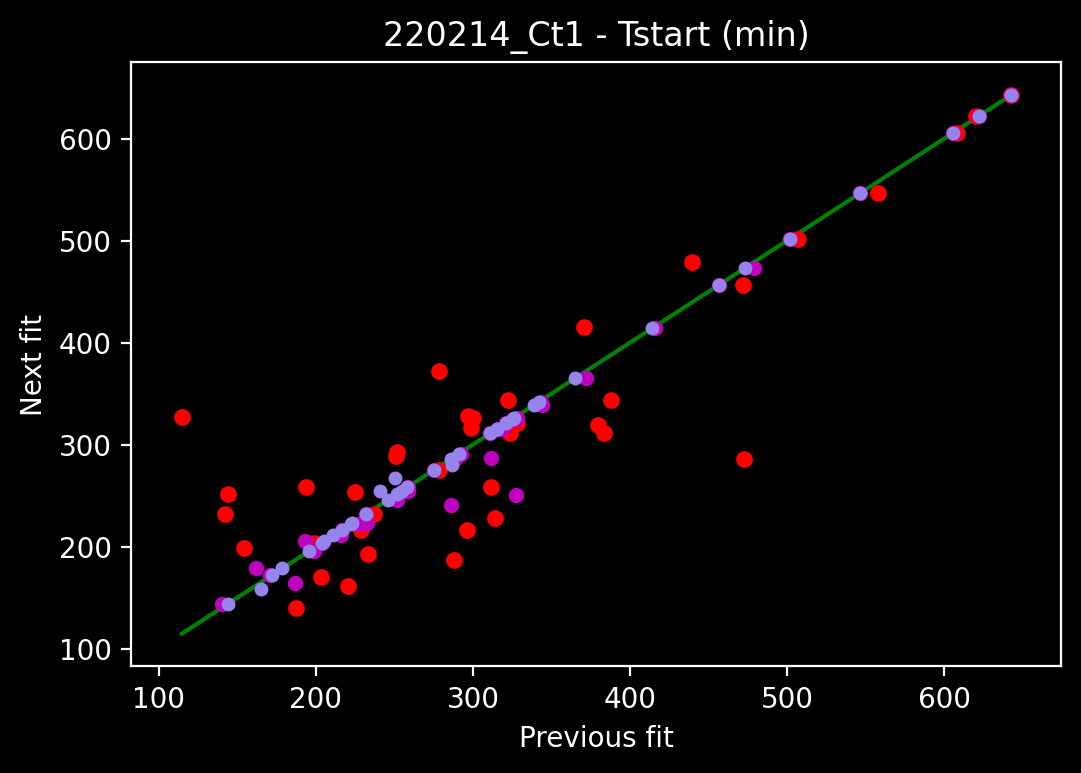

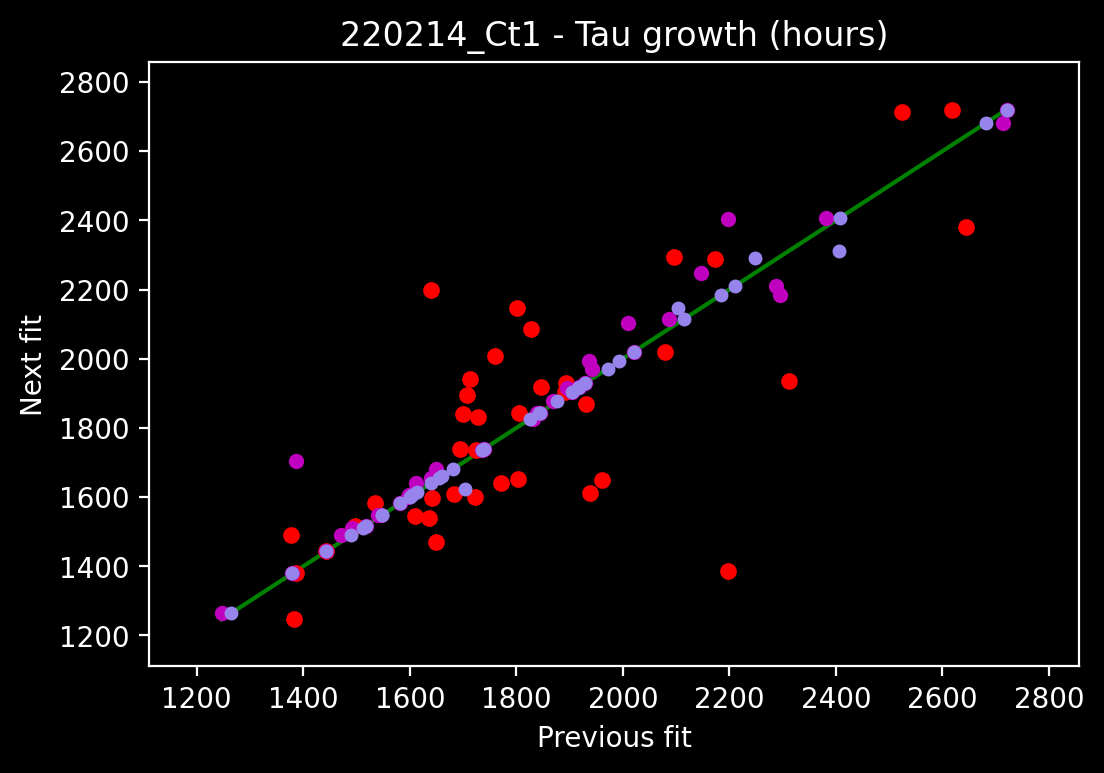

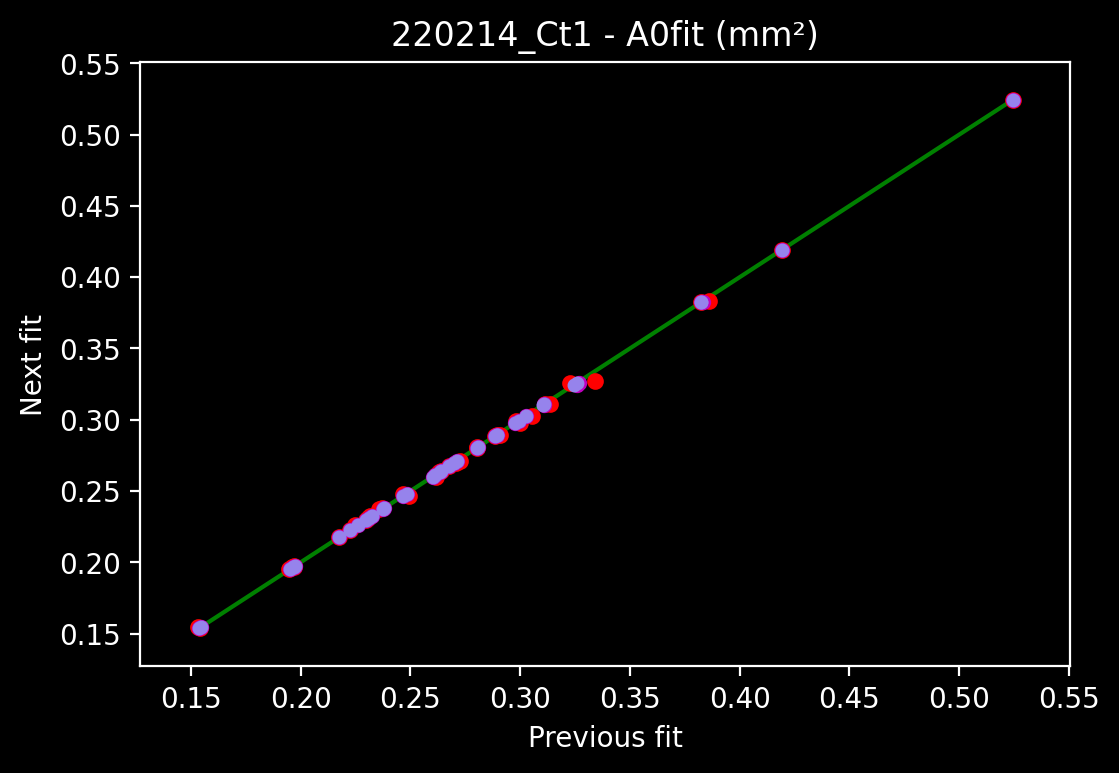

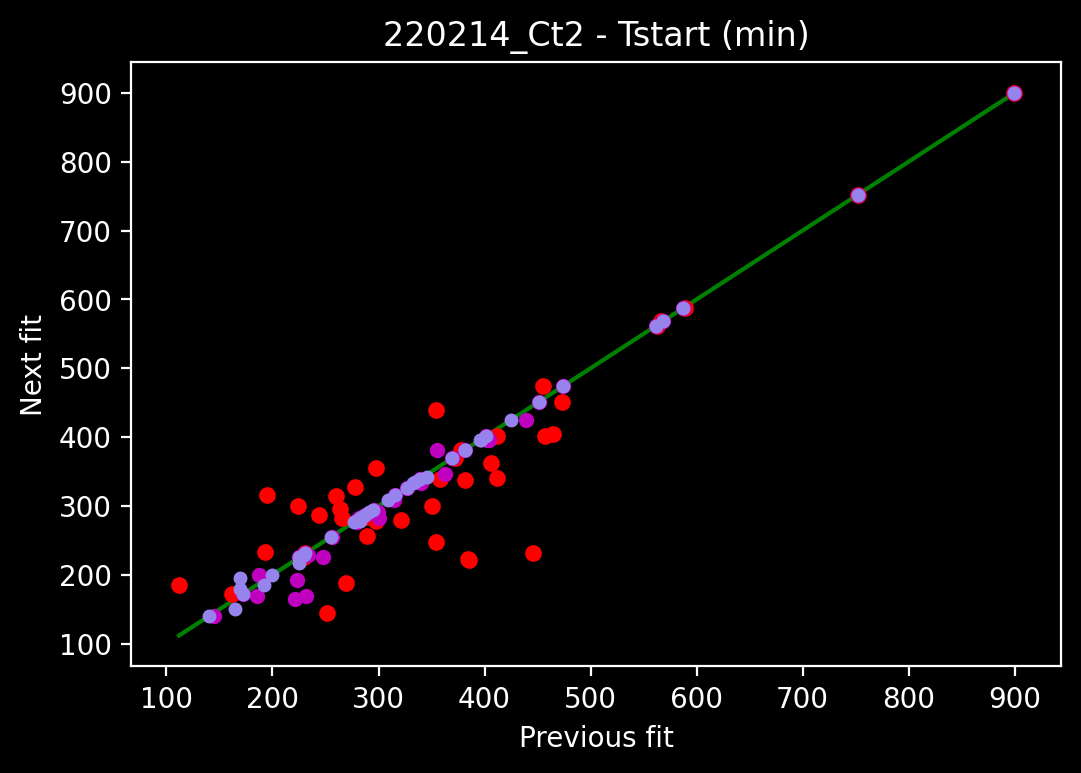

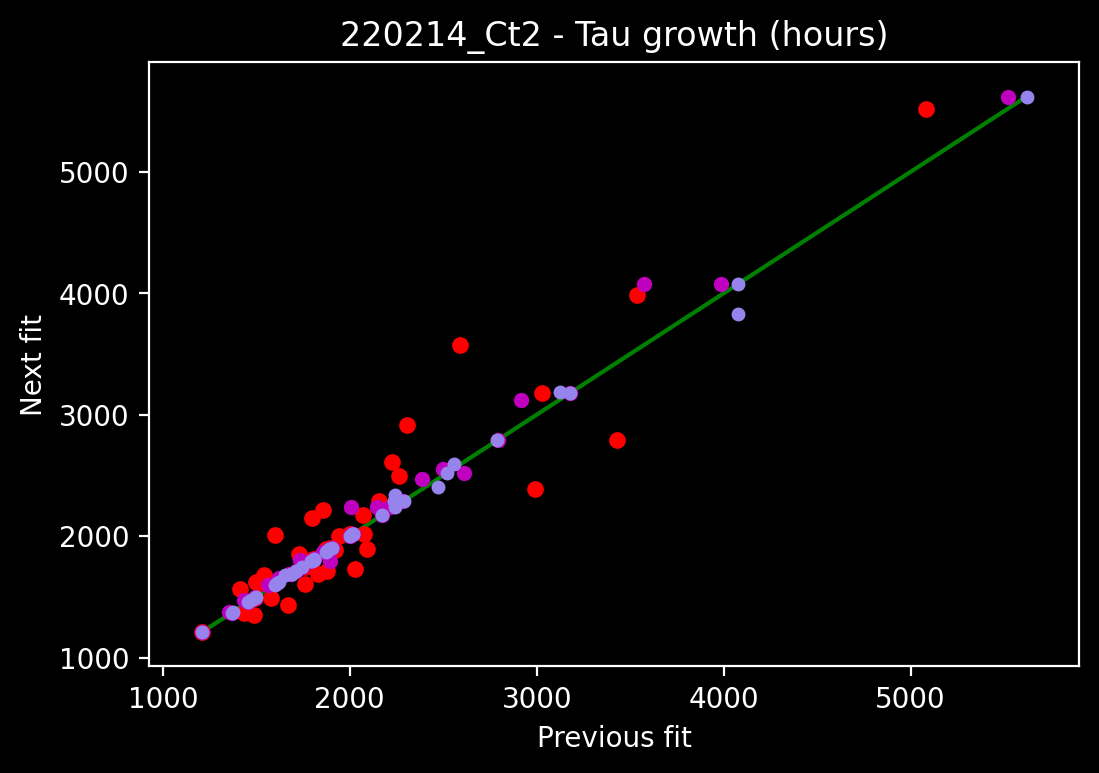

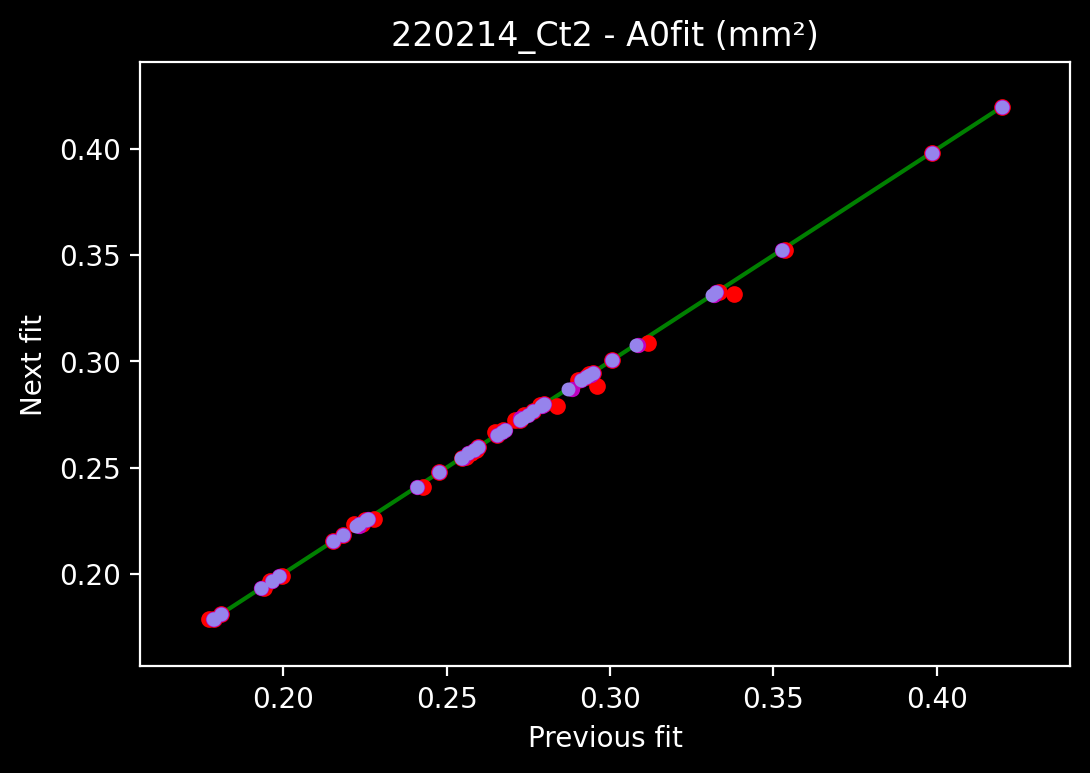

In [38]:
# BinarizeAndFitArea('220124_Ct1',StackList220124_Ct1,P220124_Ct1,Scale220124,FPH220124,Delay220124,0.95,'CF',
#                    showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)])

# BinarizeAndFitArea('220124_Ct2',StackList220124_Ct2,P220124_Ct2,Scale220124,FPH220124,Delay220124,0.95,'CF',
#                     showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)])
# 
# BinarizeAndFitArea('220203_Ct1',StackList220203_Ct1,P220203_Ct1,Scale220203,FPH220203,Delay220203,0.95,'F',
#                    showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 120,220)])

# BinarizeAndFitArea('220203_Ct2',StackList220203_Ct2,P220203_Ct2,Scale220203,FPH220203,Delay220203,0.95,'F',
#                     showHist = True, debug = False, HSVrange =[(15, 17, 60),(70, 140,220)])

BinarizeAndFitArea('220214_Ct1',StackList220214_Ct1,P220214_Ct1,Scale220214,FPH220214,Delay220214,0.95,'F',
                   showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 120,220)])

BinarizeAndFitArea('220214_Ct2',StackList220214_Ct2,P220214_Ct2,Scale220214,FPH220214,Delay220214,0.95,'F',
                   showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)])

#### Osmotic choc after 14-02-2022 




220214_Ct1_Osmo


Sorting data.


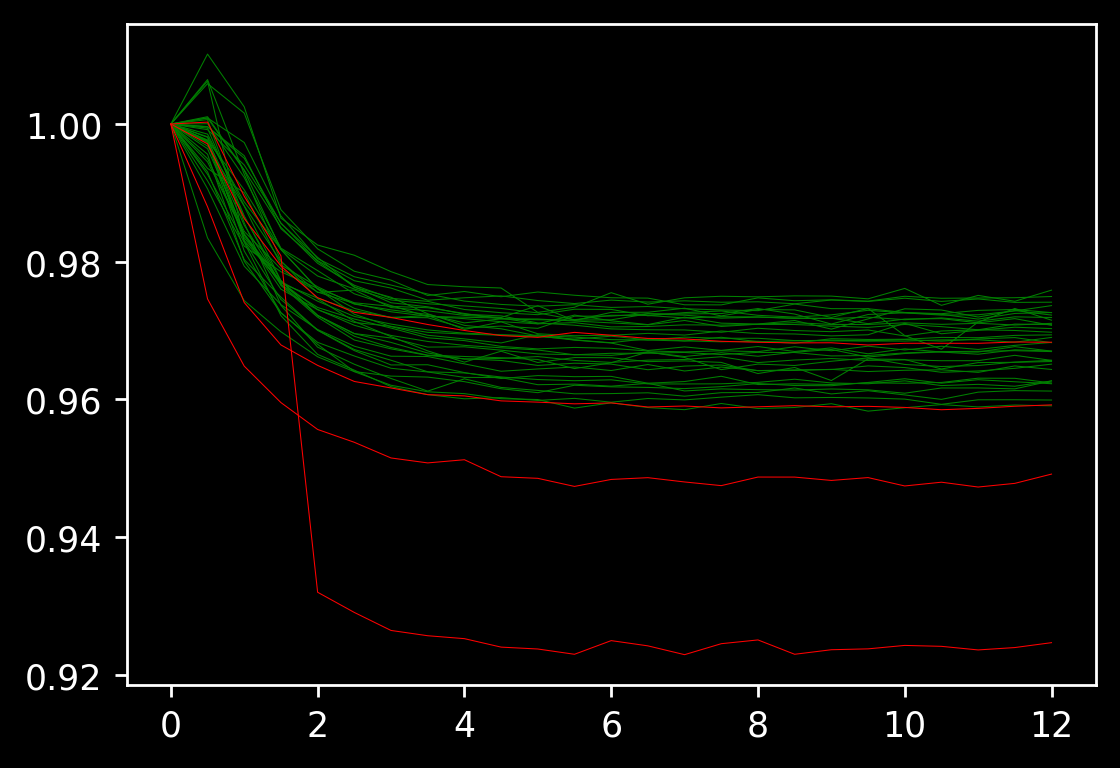

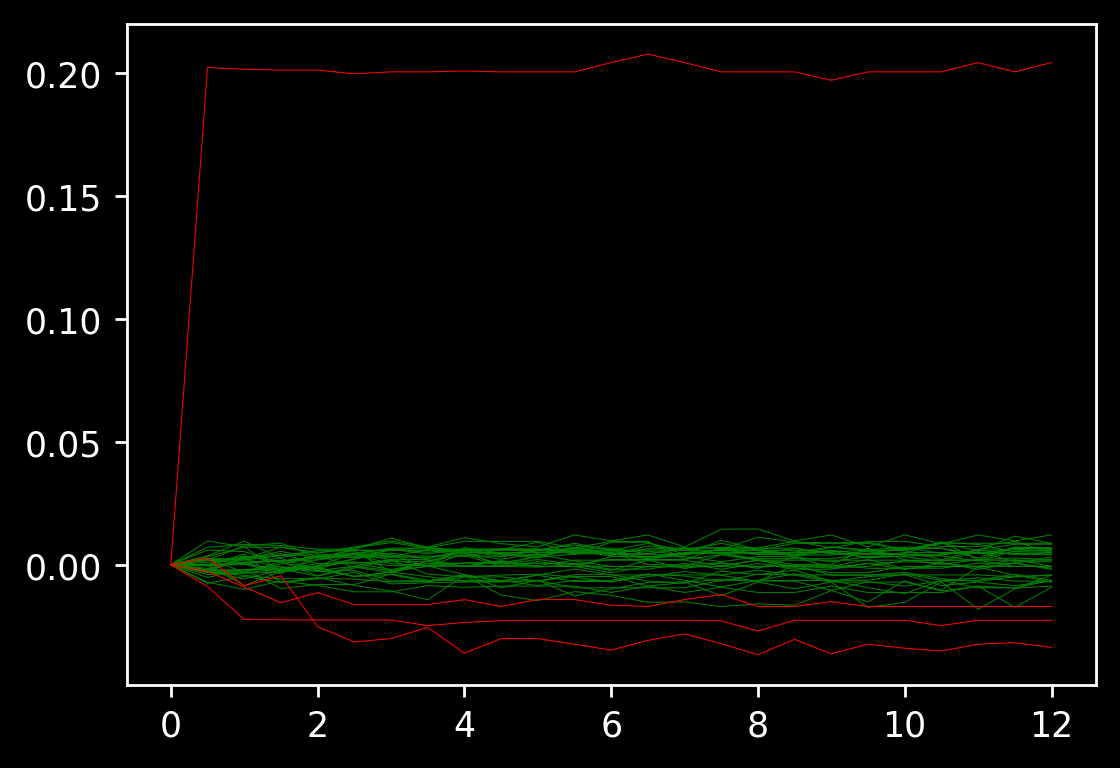

Kept 33/37PPGs (89.19%)
Fitting curve for : PPG1 
Fitting curve for : PPG4 
Fitting curve for : PPG7 
Fitting curve for : PPG9 
Fitting curve for : PPG10
Fitting curve for : PPG11
Fitting curve for : PPG12
Fitting curve for : PPG14
Fitting curve for : PPG18
Fitting curve for : PPG20
Fitting curve for : PPG21
Fitting curve for : PPG22
Fitting curve for : PPG23
Fitting curve for : PPG24
Fitting curve for : PPG26
Fitting curve for : PPG29
Fitting curve for : PPG31
Fitting curve for : PPG32
Fitting curve for : PPG33
Fitting curve for : PPG35
Fitting curve for : PPG36
Fitting curve for : PPG37
Fitting curve for : PPG38
Fitting curve for : PPG39
Fitting curve for : PPG42
Fitting curve for : PPG43
Fitting curve for : PPG45
Fitting curve for : PPG46
Fitting curve for : PPG47
Fitting curve for : PPG48
Fitting curve for : PPG52
Fitting curve for : PPG53
Fitting curve for : PPG55
Analyzing : 220214_Ct1_Osmo



220214_Ct2_Osmo


Sorting data.


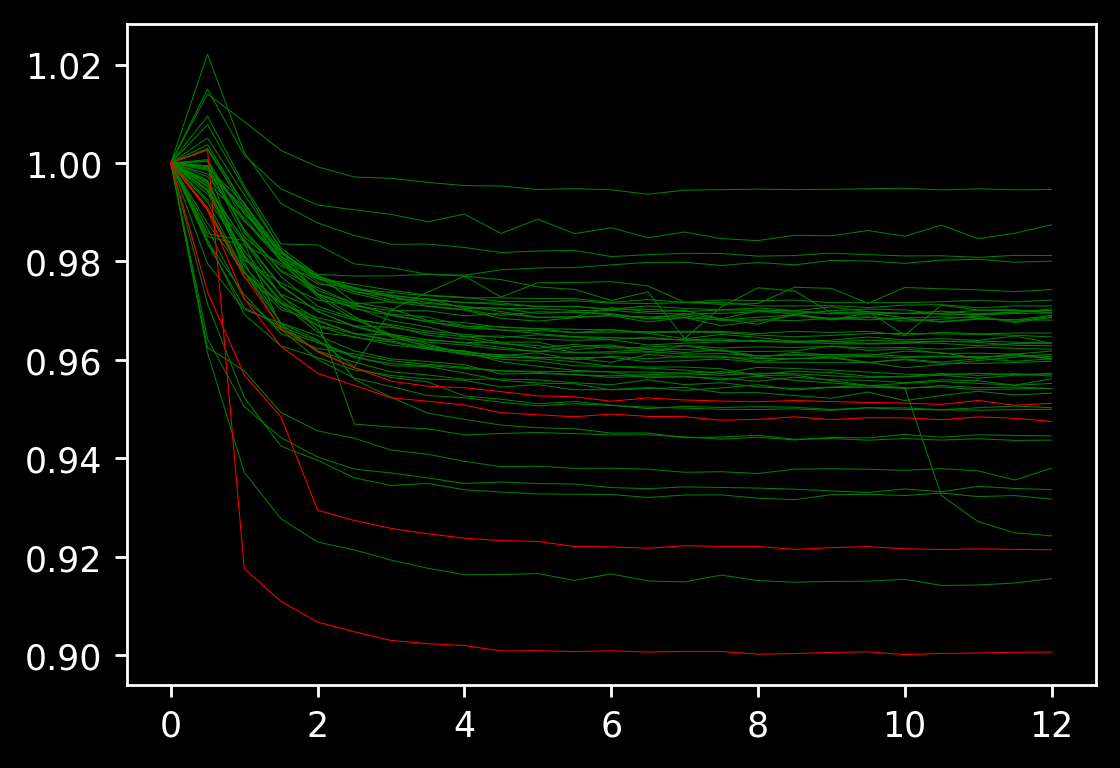

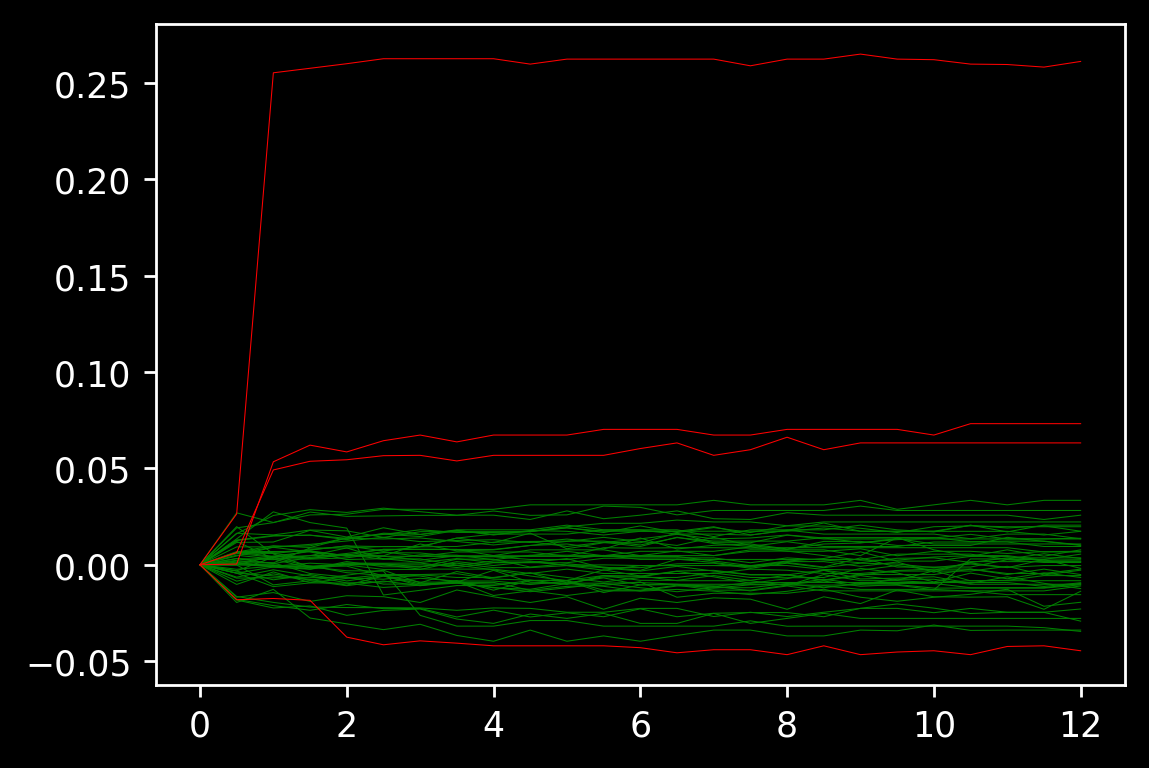

Kept 47/51PPGs (92.16%)
Fitting curve for : PPG1 
Fitting curve for : PPG5 
Fitting curve for : PPG6 
Fitting curve for : PPG7 
Fitting curve for : PPG8 
Fitting curve for : PPG9 
Fitting curve for : PPG12
Fitting curve for : PPG13
Fitting curve for : PPG14
Fitting curve for : PPG19
Fitting curve for : PPG20
Fitting curve for : PPG22
Fitting curve for : PPG23
Fitting curve for : PPG26
Fitting curve for : PPG27
Fitting curve for : PPG28
Fitting curve for : PPG29
Fitting curve for : PPG30
Fitting curve for : PPG31
Fitting curve for : PPG32
Fitting curve for : PPG33
Fitting curve for : PPG34
Fitting curve for : PPG35
Fitting curve for : PPG36
Fitting curve for : PPG37
Fitting curve for : PPG38
Fitting curve for : PPG39
Fitting curve for : PPG40
Fitting curve for : PPG42
Fitting curve for : PPG43
Fitting curve for : PPG44
Fitting curve for : PPG45
Fitting curve for : PPG46
Fitting curve for : PPG48
Fitting curve for : PPG49
Fitting curve for : PPG50
Fitting curve for : PPG51
Fitting curve 

In [39]:
BinarizeAndFitOsChoc('220214_Ct1_Osmo',StackList220214_Ct1_Osmo,P220214_Ct1_Osmo,Scale220214_Osmo,FPH220214_Osmo,0.98,'F',
                   showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)],FitInterval = [0,25])


BinarizeAndFitOsChoc('220214_Ct2_Osmo',StackList220214_Ct2_Osmo,P220214_Ct2_Osmo,Scale220214_Osmo,FPH220214_Osmo,0.98,'F',
                   showHist = False, debug = False, HSVrange =[(15, 30, 60),(70, 140,220)],FitInterval = [0,25])


#### Manitol 100mM (01-03-2022) + OC




220301_Ct


Fitting area curve for : PPG1 
Fitting area curve for : PPG2 
Fitting area curve for : PPG3 
Fitting area curve for : PPG4 
Fitting area curve for : PPG5 
Fitting area curve for : PPG6 
Fitting area curve for : PPG7 
Fitting area curve for : PPG8 
Fitting area curve for : PPG9 
Fitting area curve for : PPG10
Fitting area curve for : PPG11
Fitting area curve for : PPG12
Fitting area curve for : PPG13
Fitting area curve for : PPG14
Fitting area curve for : PPG15
Fitting area curve for : PPG16
Fitting area curve for : PPG17
Fitting area curve for : PPG18
Fitting area curve for : PPG19
Fitting area curve for : PPG20
Fitting area curve for : PPG21
Fitting area curve for : PPG22
Fitting area curve for : PPG23
Fitting area curve for : PPG24
Fitting area curve for : PPG25
Fitting area curve for : PPG26
Fitting area curve for : PPG27
Fitting area curve for : PPG28
Fitting area curve for : PPG29
Fitting area curve for : PPG30
Fitting area curve for : PPG31
Fitting area curve for :

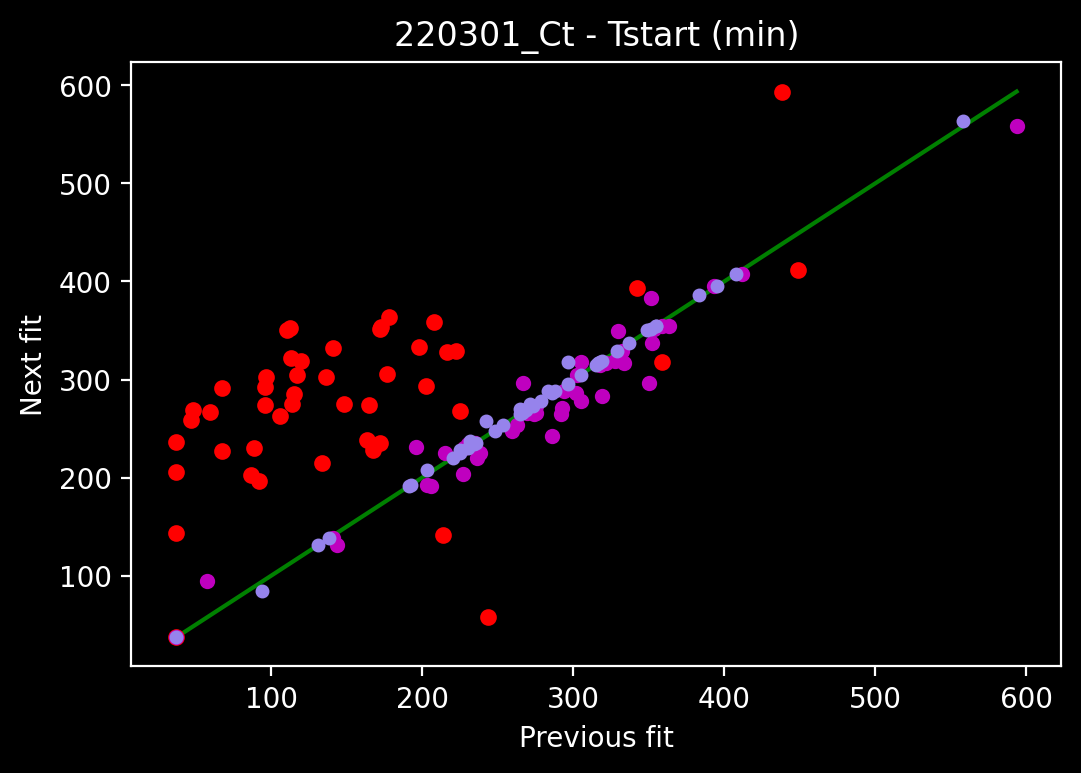

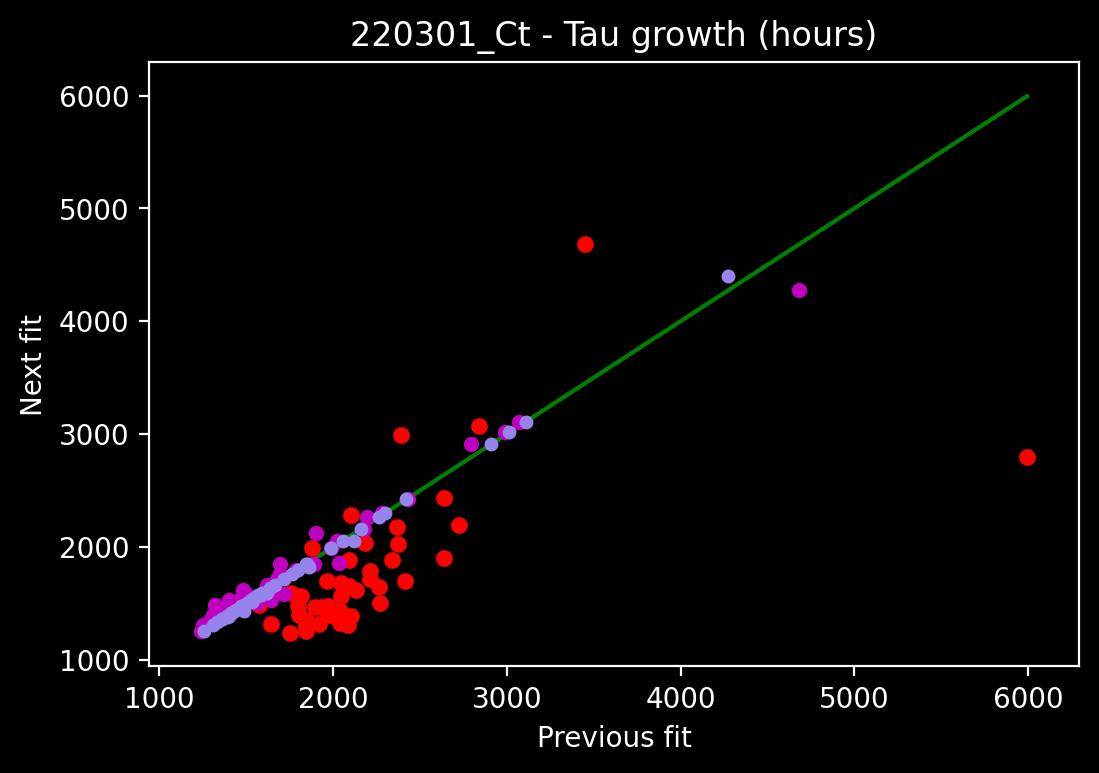

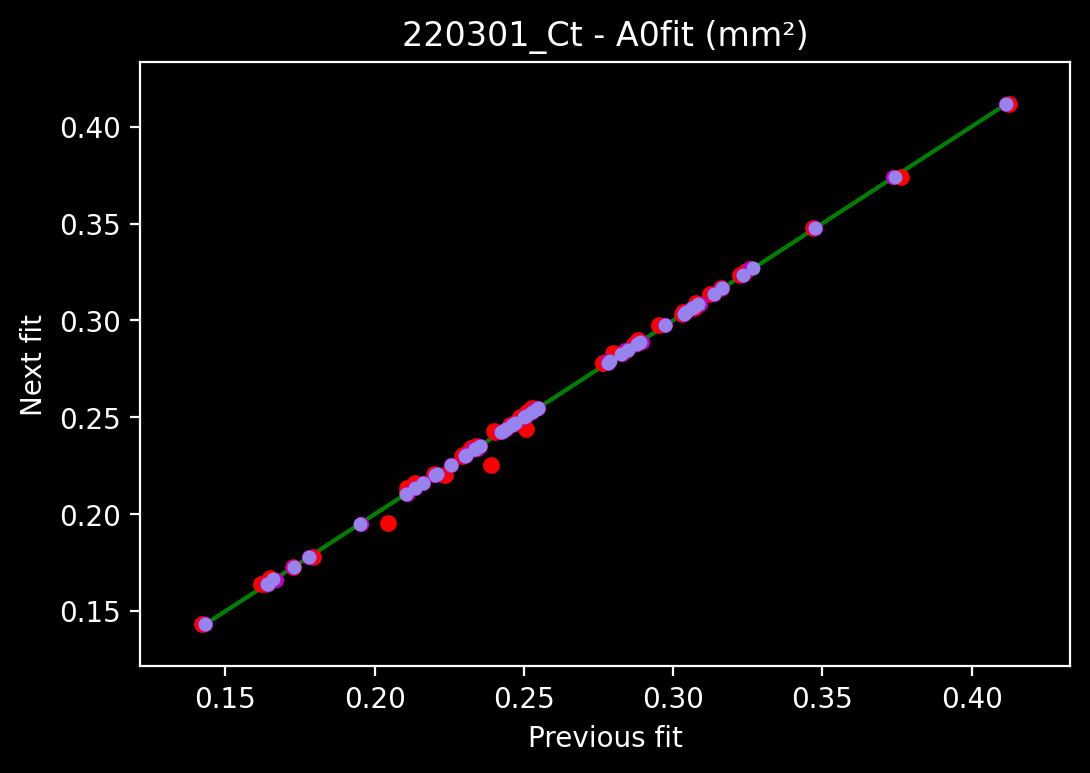

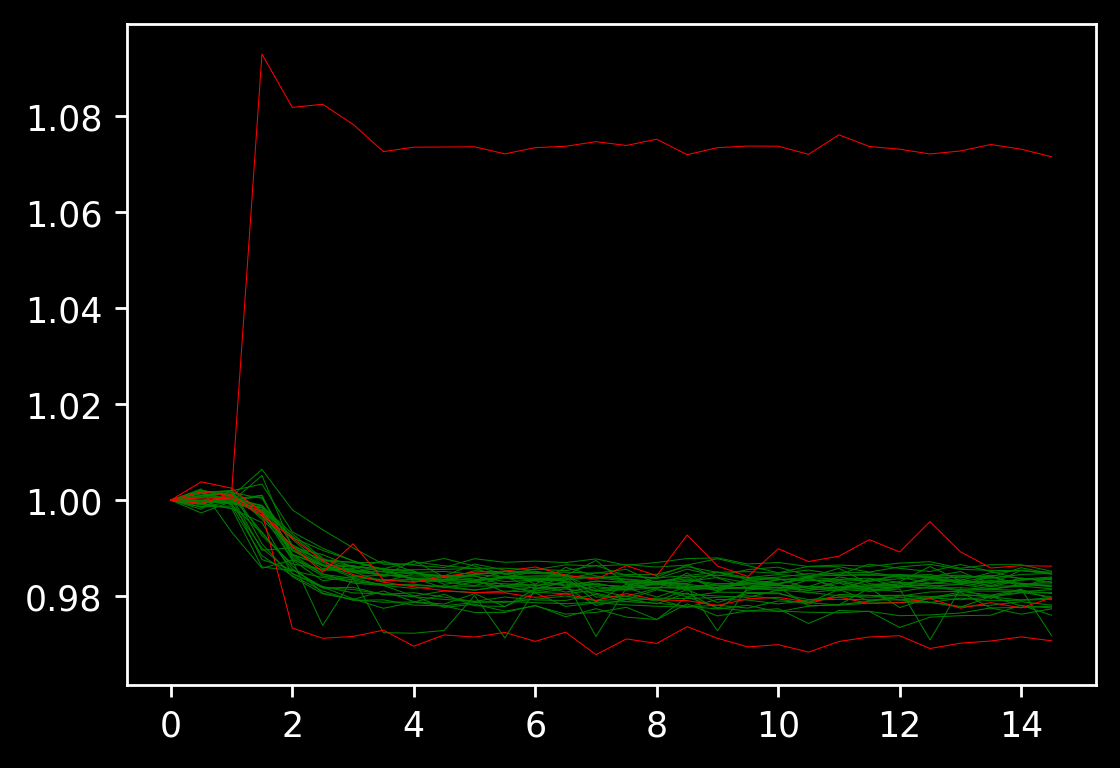

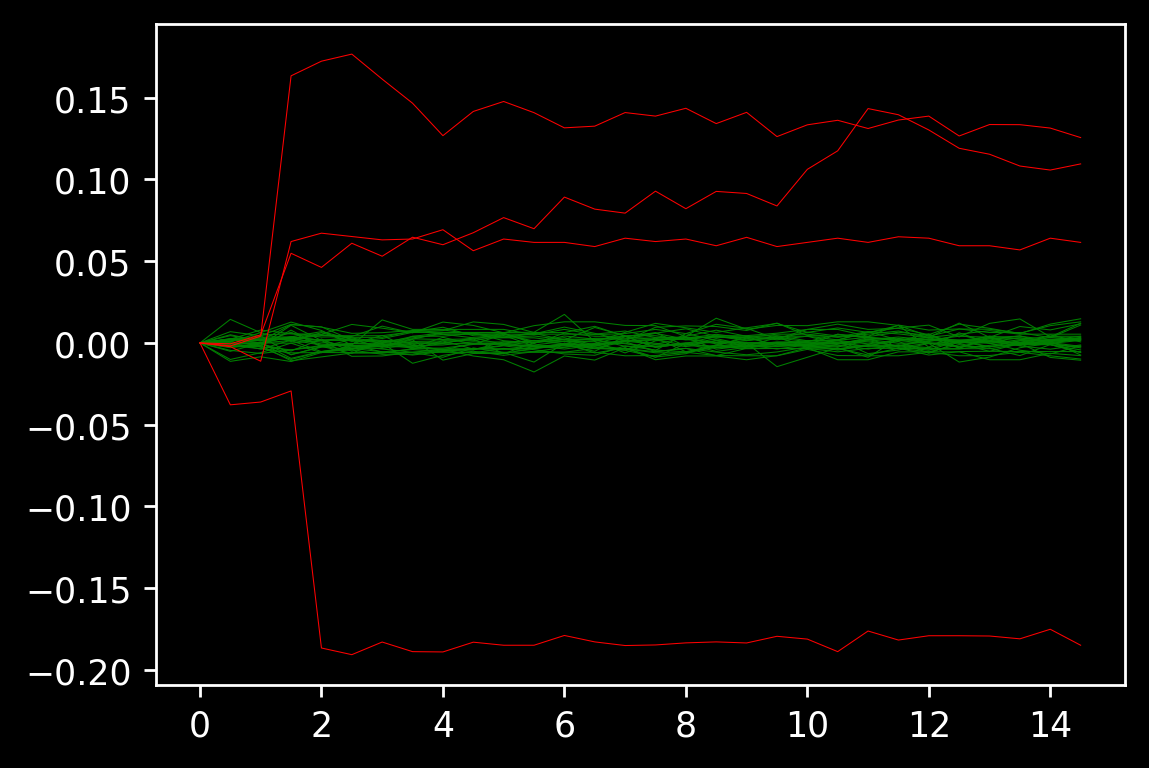

Kept 31/35PPGs (88.57%)
Fitting curve for : PPG1 
Fitting curve for : PPG4 
Fitting curve for : PPG5 
Fitting curve for : PPG6 
Fitting curve for : PPG7 
Fitting curve for : PPG8 
Fitting curve for : PPG11
Fitting curve for : PPG13
Fitting curve for : PPG14
Fitting curve for : PPG16
Fitting curve for : PPG17
Fitting curve for : PPG20
Fitting curve for : PPG24
Fitting curve for : PPG25
Fitting curve for : PPG26
Fitting curve for : PPG28
Fitting curve for : PPG29
Fitting curve for : PPG31
Fitting curve for : PPG32
Fitting curve for : PPG33
Fitting curve for : PPG36
Fitting curve for : PPG37
Fitting curve for : PPG39
Fitting curve for : PPG40
Fitting curve for : PPG41
Fitting curve for : PPG42
Fitting curve for : PPG43
Fitting curve for : PPG44
Fitting curve for : PPG45
Fitting curve for : PPG46
Fitting curve for : PPG49
Analyzing : 220301_Ct_Osmo



220301_M100


Fitting area curve for : PPG1 
Fitting area curve for : PPG2 
Fitting area curve for : PPG3 
Fitting area curve for : PPG4 
Fi

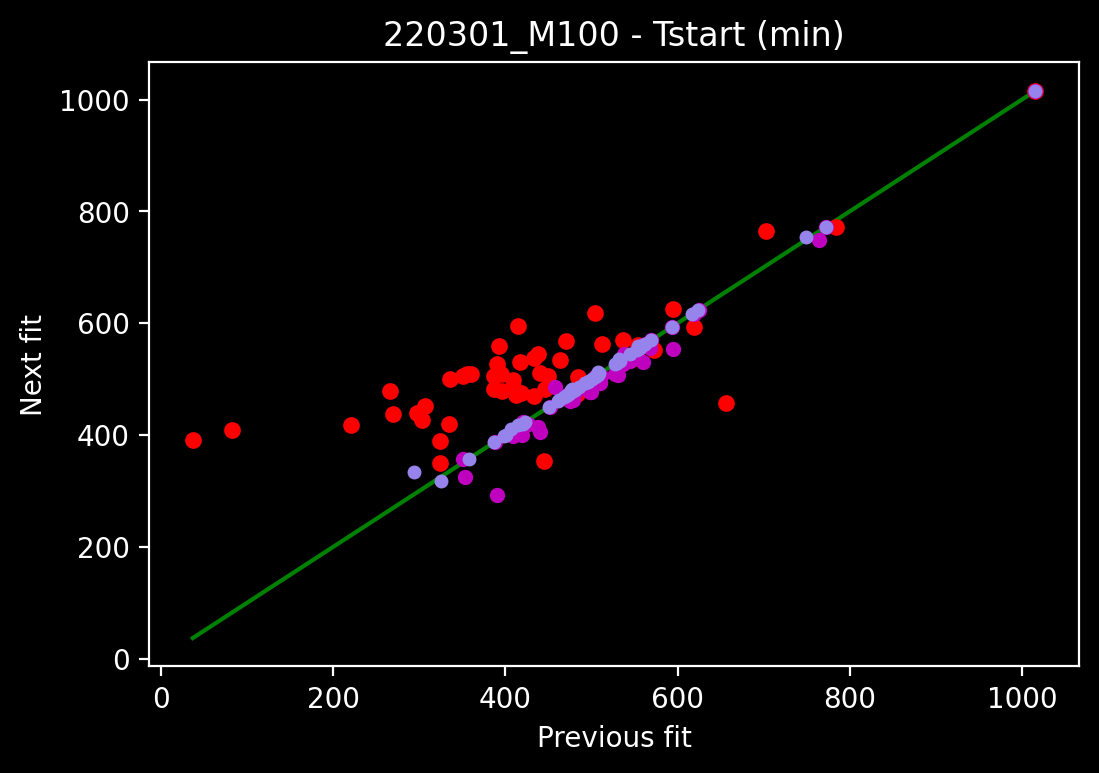

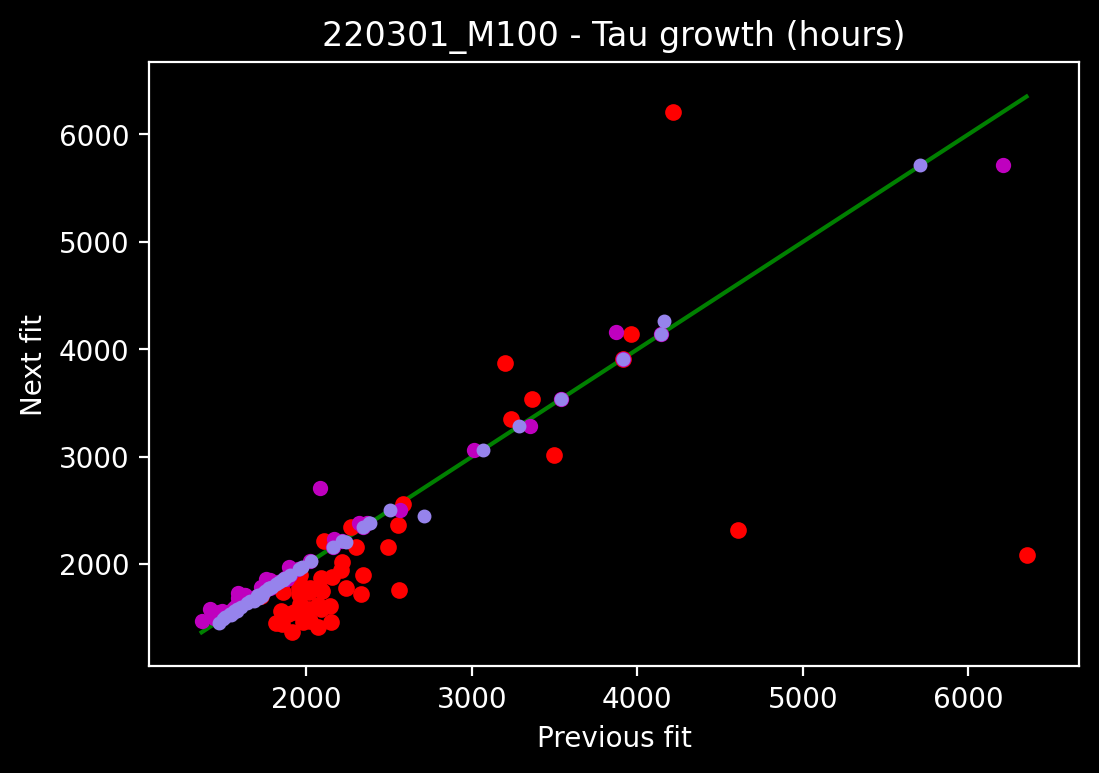

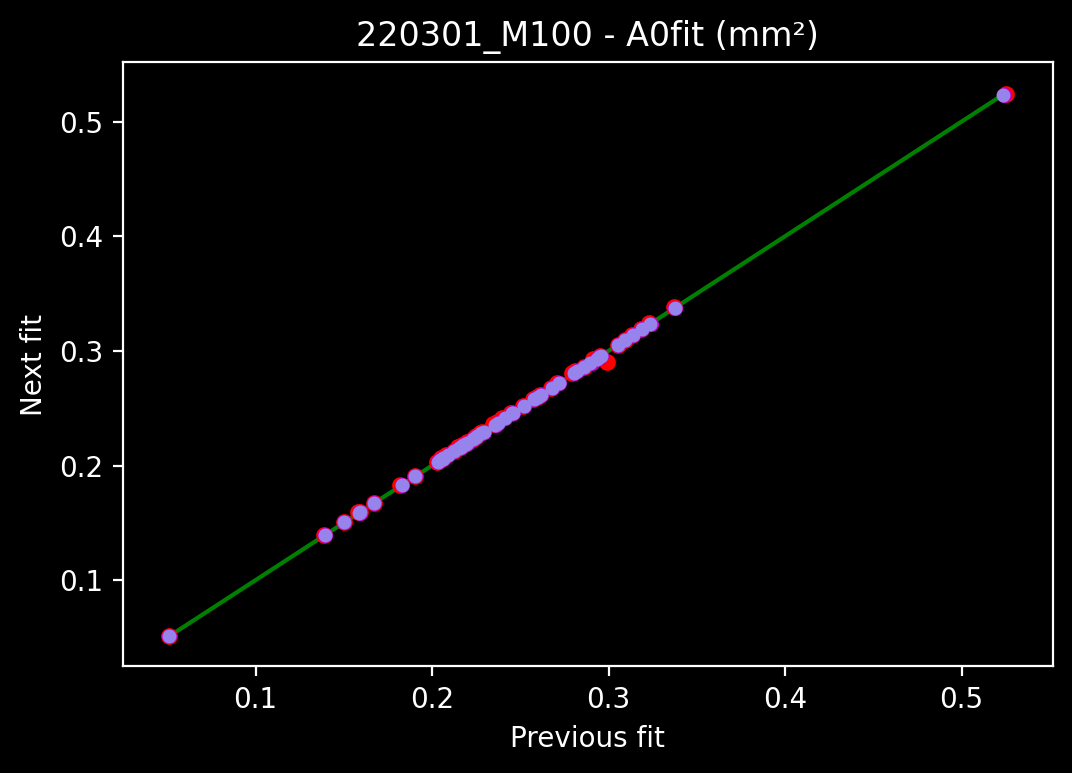

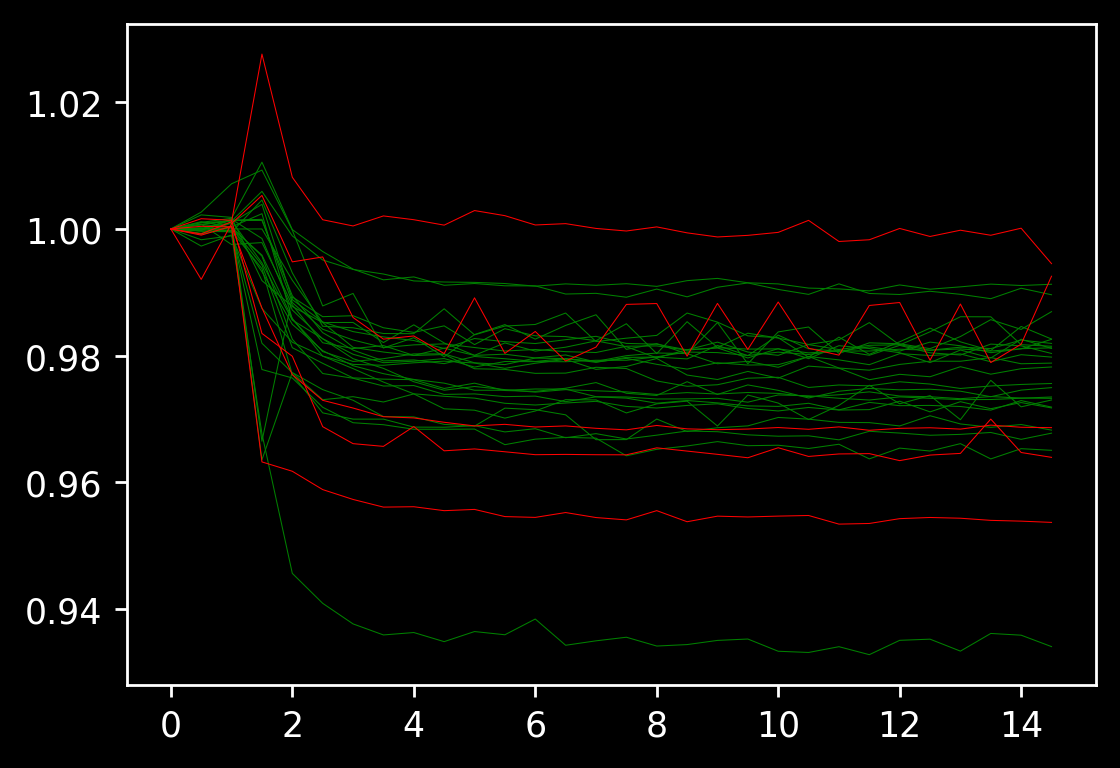

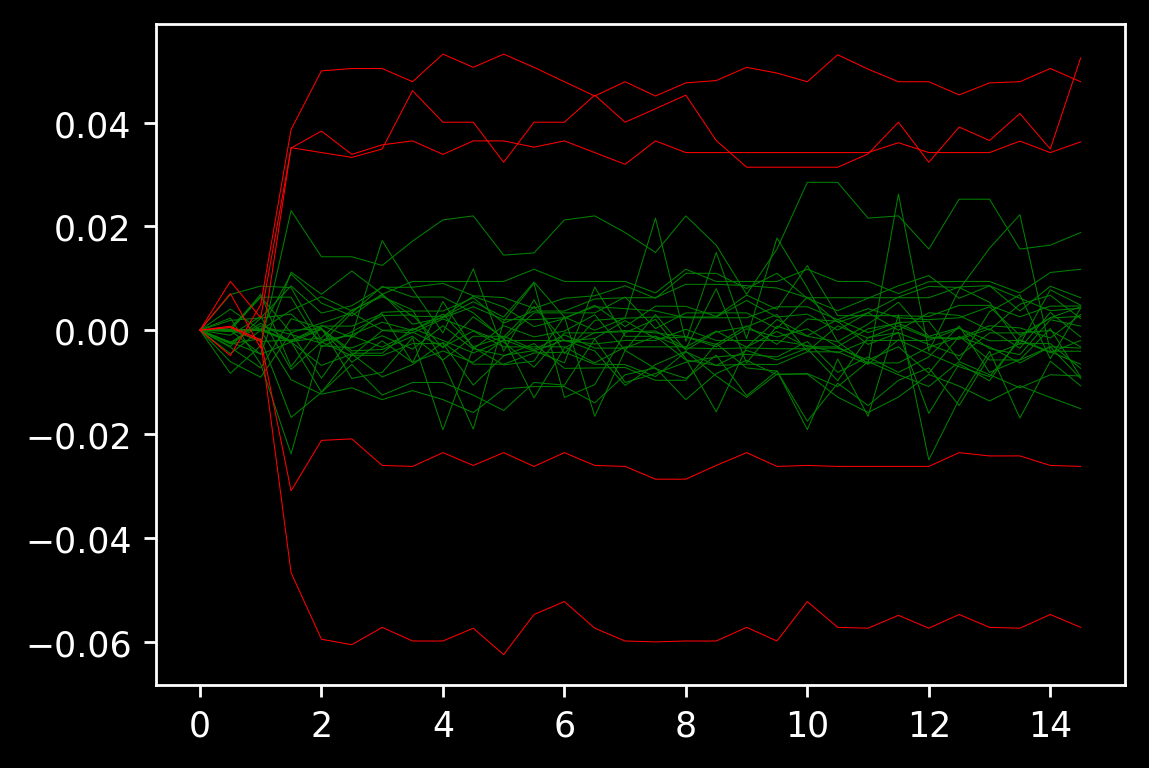

Kept 24/29PPGs (82.76%)
Fitting curve for : PPG1 
Fitting curve for : PPG7 
Fitting curve for : PPG8 
Fitting curve for : PPG10
Fitting curve for : PPG11
Fitting curve for : PPG26
Fitting curve for : PPG27
Fitting curve for : PPG28
Fitting curve for : PPG29
Fitting curve for : PPG30
Fitting curve for : PPG31
Fitting curve for : PPG34
Fitting curve for : PPG37
Fitting curve for : PPG41
Fitting curve for : PPG42
Fitting curve for : PPG43
Fitting curve for : PPG44
Fitting curve for : PPG45
Fitting curve for : PPG47
Fitting curve for : PPG49
Fitting curve for : PPGA 
Fitting curve for : PPGC 
Fitting curve for : PPGD 
Fitting curve for : PPGE 
Analyzing : 220301_M100_Osmo


In [40]:
BinarizeAndFitArea('220301_Ct',StackList220301_Ct,P220301_Ct,Scale220301,FPH220301,Delay220301,0.9,'F',
                   showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)])
BinarizeAndFitOsChoc('220301_Ct_Osmo',StackList220301_Ct_Osmo,P220301_Ct_Osmo,Scale220301_Osmo,FPH220301_Osmo,0.95,'F',
                   showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)],FitInterval = [0,30])

BinarizeAndFitArea('220301_M100',StackList220301_M100,P220301_M100,Scale220301,FPH220301,Delay220301,0.9,'F',
                   showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)])
BinarizeAndFitOsChoc('220301_M100_Osmo',StackList220301_M100_Osmo,P220301_M100_Osmo,Scale220301_Osmo,FPH220301_Osmo,0.95,'F',
                   showHist = False, debug = False, debuglist = [0], HSVrange =[(15, 17, 60),(70, 140,220)],FitInterval = [0,30])

#### Ctrls DV6 +OC (05/04/22)

In [41]:
BinarizeAndFitArea('220405_Ct1',StackList220405_Ct1,P220405_Ct1,Scale220405,FPH220405,Delay220405,0.95,'BCF',
                   showHist = True, debug = False, debuglist = [0,10,23,38],HSVrange =[(15, 15, 60),(70, 120,220)])

# BinarizeAndFitArea('220405_Ct2',StackList220405_Ct2,P220405_Ct2,Scale220405,FPH220405,Delay220405,0.95,'B',
#                    showHist = True, debug = True, HSVrange =[(15, 30, 60),(70, 140,220)])

BinarizeAndFitOsChoc('220405_Ct1_Osmo',StackList220405_Ct1_Osmo,P220405_Ct1_Osmo,Scale220405_Osmo,FPH220405_Osmo,0.98,'BCF',
                   showHist = True, debug = False, debuglist = [0,10,23,38], HSVrange =[(15, 25, 60),(70, 140,220)],FitInterval = [0,25])


# BinarizeAndFitOsChoc('220405_Ct2_Osmo',StackList220405_Ct2_Osmo,P220405_Ct2_Osmo,Scale220405_Osmo,FPH220405_Osmo,0.98,'B',
#                    showHist = False, debug = True, HSVrange =[(15, 30, 60),(70, 140,220)],FitInterval = [0,25])





220405_Ct1


Processing PPG1 :
Binarization done for 61/61 images             
Processing PPG2 :
Binarization done for 61/61 images             
Processing PPG3 :
Binarization done for 61/61 images             
Processing PPG4 :
Binarization done for 61/61 images             
Processing PPG5 :
Binarization done for 61/61 images             
Processing PPG6 :
Binarization done for 61/61 images             
Processing PPG7 :
Binarization done for 61/61 images             
Processing PPG8 :
Binarization done for 61/61 images             
Processing PPG9 :
Binarization done for 61/61 images             
Processing PPG10 :
Binarization done for 61/61 images             
Processing PPG11 :
Binarization done for 61/61 images             
Processing PPG12 :
Binarization done for 61/61 images             
Processing PPG13 :
Binarization done for 61/61 images             
Processing PPG14 :
Binarization done for 61/61 images             
Processing PPG15 :
Binarization done for 61/61 images  

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['PPG35'], dtype='object', name='Name'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

## Test Zone

In [ ]:
print('It works!')

In [ ]:
# %run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/PropaguleAnalysis/2_AreaAnalysis.ipynb